#### Pakkar

In [118]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import stop_words
import string
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten, Input, Embedding
from tensorflow.python.keras.optimizers import Adadelta
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, GRU
import tensorflow as tf

In [90]:
tf.compat.v1.disable_eager_execution()

#### Innlestur gagna

In [101]:
train_data = pd.read_csv('data/train.csv',delimiter=',')

test_data = pd.read_csv('data/test.csv',delimiter=',')


### Gagnasettið
Hér má sjá gagnasettið sem við þjálfum módelið á. Við erum með comment_text og hann er búið að greina (0 eða 1) hvort hann sé toxic, severe_toxic, obscene, threat, insult eða identity_hate.

In [92]:
display(train_data.head())
cols = train_data.columns
print('Dálkarnir eru: ')
for col in cols:
    print('- \t',col)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Dálkarnir eru: 
- 	 id
- 	 comment_text
- 	 toxic
- 	 severe_toxic
- 	 obscene
- 	 threat
- 	 insult
- 	 identity_hate


In [153]:
display(test_data.head())

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
# Nota þetta til að testa loka módelið
x_testLoka = test_data[cols[1]]
y_testLoka = test_data[cols[2:]]

### Text preprocessing


In [93]:

def textpreprocess(sentence):
    sentence = sentence.lower()
    
    #Taka út ensk stopporð
    stopwords = stop_words.ENGLISH_STOP_WORDS
    for sw in stopwords:
        if len(sw) > 1 and sw in sentence:
            sentence.replace(sw,'')
    
    #Taka út tölur
    sentence = ''.join([i for i in sentence if not i.isdigit()])
    
    #Taka út punkta, kommur og þannig lagað
    sentence=sentence.translate(str.maketrans('', '', string.punctuation))
    
    return sentence

Hér er þá búið að preprocessa textann

In [94]:
def getProcessedText(dataset):
    x_train = dataset['comment_text'].to_numpy()
    for i in range(len(x_train)):
        x_train[i] = textpreprocess(x_train[i])
    return x_train

In [102]:
x_train = train_data['comment_text'].to_numpy()
for i in range(len(x_train)):
    x_train[i] = textpreprocess(x_train[i])

In [96]:
max_comment_length = len(train_data['comment_text'][0])

for comment in train_data['comment_text']:
    if len(comment) > maxlen:
        max_comment_length = len(comment)
print(maxlen)

5000


In [147]:
def getSubet(dataset, size):
    return dataset[0:size]

Prófa að exclude-a bara toxic dálkinn og gera model á honum

In [97]:
toxicCol = train_data['toxic']
classes = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

In [103]:
# X_train = train_data['comment_text'].to_numpy()
X_train = x_train
# y_train = (train_data.values[:,2:])
y_train = train_data[classes]
print(len(y_train), len(X_train))
# Set aside validation data for monitoring training progress

assert len(X_train) == len(y_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

print('=================')
print('|','train_data shape:', X_train.shape)
print('|',X_train.shape[0], 'train samples')
print('|',y_test.shape[0], 'test samples')
print('=================')

159571 159571
| train_data shape: (127656,)
| 127656 train samples
| 31915 test samples


In [169]:
size=10000
X_train, X_test, y_train, y_test = getSubet(X_train,size), getSubet(X_test,size),getSubet(y_train,size), getSubet(y_test,size)

In [170]:
input_shape = (y_train.shape)
print(input_shape)

(10000, 6)


In [171]:
max_words = 20000 # <- spurning um hvað þetta eigi að vera
output_vector_len = int(train_data.fillna('').astype(str).apply(lambda x:x.str.len()).mean()[1])
tokenizer = text.Tokenizer(num_words=max_words)
num_classes = 6

tokenizer.fit_on_texts(list(X_train))
tokTrain = tokenizer.texts_to_sequences(X_train)
tokTest = tokenizer.texts_to_sequences(X_test)

x_train=sequence.pad_sequences(tokTrain, maxlen=max_comment_length)
x_test=sequence.pad_sequences(tokTest, maxlen=max_comment_length)


In [ ]:
## PRÓFA þetta
model = Sequential()
model.add(Dropout(0.5))
model.add(Conv1D(filters=32,kernel_size=2,
                activation='relu', padding="same"))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=2,
                activation='relu', padding="same"))
model.add(MaxPooling1D(pool_size=2))
# model.add(GRU(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Model(inputs=inp,outputs=model))
model.compile(loss='binary_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
model.summary()

#### Góð útskýring á multilabel classifier
https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24

In [172]:
inp = Input(shape=(max_comment_length,))
model = Embedding(max_words, output_vector_len)(inp) 
#Embedded útskýring:
    #Turns positive integers (indexes) into dense vectors of fixed size.
######

#####
model = Dropout(0.5)(model)
model = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(model)
model = MaxPooling1D(pool_size=2)(model)
model = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(model)
model = MaxPooling1D(pool_size=2)(model)
model = GRU(128)(model)
# model = Dense(128, activation="relu")(model)
model = Dense(64, activation="relu")(model)
model = Dense(32, activation="relu")(model)
model = Dense(16, activation="relu")(model)
model = Dense(6, activation="softmax")(model)
model = Model(inputs=inp, outputs=model)
model.compile(loss='binary_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
# model.compile(loss='sparse_categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 245)]             0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 245, 374)          7480000   
_________________________________________________________________
dropout_17 (Dropout)         (None, 245, 374)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 245, 32)           23968     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 122, 32)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 122, 32)           2080      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 61, 32)            0   

In [139]:
#Sjá hvernig y- þjálfunargögnin líta út
print(y_train[:5])

        toxic  severe_toxic  obscene  threat  insult  identity_hate
107429      0             0        0       0       0              0
152607      0             0        0       0       0              0
58863       0             0        0       0       0              0
76274       0             0        0       0       0              0
107023      0             0        0       0       0              0


In [173]:
batch_size = 32
epochs = 8
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 1,
                    validation_split=0.1)
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

print('Test acc: {}'.format(score[1]))

Train on 9000 samples, validate on 1000 samples
Epoch 1/8
9000/9000 [==============================] - 64s 7ms/sample - loss: 0.2350 - accuracy: 0.9625 - val_loss: 0.2279 - val_accuracy: 0.9663
Epoch 2/8
9000/9000 [==============================] - 58s 6ms/sample - loss: 0.2315 - accuracy: 0.9625 - val_loss: 0.2276 - val_accuracy: 0.9663
Epoch 3/8
9000/9000 [==============================] - 56s 6ms/sample - loss: 0.2314 - accuracy: 0.9625 - val_loss: 0.2278 - val_accuracy: 0.9663
Epoch 4/8
9000/9000 [==============================] - 56s 6ms/sample - loss: 0.2311 - accuracy: 0.9625 - val_loss: 0.2273 - val_accuracy: 0.9663
Epoch 5/8
9000/9000 [==============================] - 56s 6ms/sample - loss: 0.2308 - accuracy: 0.9625 - val_loss: 0.2266 - val_accuracy: 0.9663
Epoch 6/8
9000/9000 [==============================] - 56s 6ms/sample - loss: 0.2301 - accuracy: 0.9625 - val_loss: 0.2259 - val_accuracy: 0.9663
Epoch 7/8
9000/9000 [==============================] - 56s 6ms/sample - loss

In [160]:
import matplotlib.pyplot as plt
def teikna(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.plot(val_loss)
    plt.plot(loss)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation','val. loss', 'loss'])
    mynd = plt.show()
    return mynd

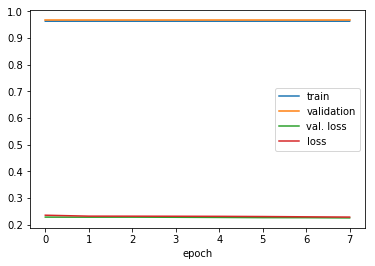

In [174]:
teikna(history)